In [70]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy.spatial import distance_matrix

number_cities = 20

'''
Generate city names in alphabetical order
'''
cities = []

for i in range(number_cities):
    city = chr(ord('A') + i)
    cities.append(city)

'''
Origin of the graph
'''
depot_longitude       =  -79.383292
depot_latitude        =  43.652224

'''
Generate random coordinates
'''
longitude = np.random.normal(depot_longitude, 0.1, number_cities)
latitude  = np.random.normal(depot_latitude, 0.1, number_cities)


'''
Generate random demands per cities
'''
demands = np.random.randint(1, 11, number_cities-1)
demands = np.insert(demands,0,0)
print(demands)


'''
Insert coordinates in a matrix
'''
coords  =  []
k       =  0
for citie in range(len(cities)):
    coords.append([abs(round(longitude[k]*100000)), abs(round(latitude[k]*100000))])
    k += 1



print(coords)
df      = pd.DataFrame(coords, columns=['xcord', 'ycord'],    index=cities)
#df     = pd.DataFrame({"longitude":longitude,
#                       "latitude":latitude},  index=cities)

df_map = pd.DataFrame({"longitude":longitude,
                       "latitude":latitude,
                       "demand":demands},  index=cities)
print(df)
print("-------------------------------")
print(df_map)

[ 0  3  4  1  4  8  4 10  2 10  1  4  2  7  7  7  7  7  9  2]
[[7927336, 4357321], [7933859, 4374542], [7962649, 4356386], [7940038, 4372929], [7943807, 4358104], [7947190, 4359310], [7937554, 4378232], [7923299, 4378402], [7934658, 4368578], [7929064, 4360098], [7943225, 4369870], [7934924, 4355688], [7932914, 4354470], [7936050, 4351800], [7937454, 4381815], [7925698, 4365180], [7928780, 4366088], [7936590, 4368660], [7926982, 4366512], [7954879, 4373084]]
     xcord    ycord
A  7927336  4357321
B  7933859  4374542
C  7962649  4356386
D  7940038  4372929
E  7943807  4358104
F  7947190  4359310
G  7937554  4378232
H  7923299  4378402
I  7934658  4368578
J  7929064  4360098
K  7943225  4369870
L  7934924  4355688
M  7932914  4354470
N  7936050  4351800
O  7937454  4381815
P  7925698  4365180
Q  7928780  4366088
R  7936590  4368660
S  7926982  4366512
T  7954879  4373084
-------------------------------
   longitude   latitude  demand
A -79.273357  43.573212       0
B -79.338590  43.7454

In [46]:
longitude, latitude = coords.T                                   # We define that the first value of coords is X and the second is Y
plt.plot(longitude[0], latitude[0], c='r', marker='s')
plt.scatter(longitude[1:],latitude[1:], c='b')             # Put the x and y axis in pyplot
plt.show()                                  # Display the coordinates of the cities on an orthonormal coordinate system

AttributeError: 'list' object has no attribute 'T'

In [71]:
'''
Creation of the matrix of distances between cities
'''

matrix   = distance_matrix(df.values, df.values)
distance = pd.DataFrame(matrix, index=df.index, columns=df.index)
print(matrix)
print("--------------------------")
print(distance)

[[    0.         18415.00393701 35325.37606311 20123.38112743
  16489.60066224 19953.3815931  23273.96496087 21464.06135847
  13428.7651331   3270.73584993 20246.91882732  7761.72873785
   6264.36628878 10315.77612204 26501.5086363   8027.8842169
   8885.1238033  14635.89549703  9197.81479483 31734.66587188]
 [18415.00393701     0.         34036.81001504  6386.06373285
  19213.8113866  20241.77326718  5221.98477593 11243.36248637
   6017.28319094 15219.10513138 10466.59161332 18884.05520538
  20094.23322747 22847.29841797  8112.98674965 12419.70068077
   9862.37075961  6485.08172655 10572.32372754 21070.50459766]
 [35325.37606311 34036.81001504     0.         28016.5695616
  18920.16088727 15733.10067978 33271.71082166 45090.20687466
  30530.98336117 33789.51270735 23645.50764945 27733.78497429
  29796.66560204 26991.44673781 35796.95609965 37983.03354131
  35231.20726004 28804.90508577 37076.55276587 18417.27732321]
 [20123.38112743  6386.06373285 28016.5695616      0.
  15296.600472 

In [92]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from time import time


class VPR:

    def __init__(self, n_trucks, capacity, demands, distance_matrix):
        self.n_trucks              =   n_trucks                   # Number of trucks
        self.dimension             =   number_cities              # Dimension of the matrix
        self.capacity              =   capacity                   # Capacity for trucks
        self.demands               =   demands                    # List of demands per edge
        self.distance_matrix       =   distance_matrix            # Distance Matrix between edge
        self.distance_matrix_sum   =   distance_matrix.sum()      # Get the sum of all the distance value
        self.final_cost            =   self.distance_matrix_sum   # Final Result / We need a first (worst) value to compare after
        self.final_sol             =   None                       # Final Solution of Tour

        self.iterations            =   None                       # Number of iterations
        self.n_ants                =   None                       # Number of ants
        self.alpha                 =   None                       # alpha: exponenet on pheromone, higher alpha gives pheromone more weight
        self.beta                  =   None                       # beta: exponent on distance, higher beta give distance more weight
        self.decay                 =   None                       # decay: Rate it which pheromone decays. The pheromone value is multiplied by decay, so 0.95 will lead to decay, 0.5 to much faster decay.
        self.init_pheromone_value  =   None                       # Number of pheromone at the start in each vertices
        self.pheromone_map         =   None                       # Number of pheromone per edge in a matrix
        self.raw_prob_matrix       =   None                       # Matrix of probability between edge

        self.city_visited          =   None                       # Array of 0 and 1 per city to know if you have been in a city. 0 -> visited and 1 -> not visited.
        self.city_visited_sum      =   None                       # Number of visited cities
        self.capacity_left         =   None                       # Capacity left in a truck

    def get_probality(self, raw_prob_list):
        prob_list = raw_prob_list/raw_prob_list.sum()
        return prob_list

    def get_next_vertex(self, pos):
        potential      =  deepcopy(self.city_visited)
        potential_sum  =  self.city_visited_sum
        while potential_sum < self.dimension:
            raw_prob_list  =  deepcopy(self.raw_prob_matrix[pos]) * potential
            next_vertex    =  np.random.choice(np.arange(0, self.dimension), p=self.get_probality(raw_prob_list))
            if self.demands[next_vertex] <= self.capacity_left:
                return next_vertex
            potential[next_vertex]  =  0
            potential_sum          +=  1
        return 0

    def local_update(self, i, j):
        self.pheromone_map[i, j]  += self.decay * self.init_pheromone_value / self.distance_matrix[i, j]
        self.pheromone_map[j, i]   = self.pheromone_map[i, j]
        self.raw_prob_matrix[i, j] = self.raw_prob_matrix[j, i] = (self.pheromone_map[i, j] ** self.alpha) * \
                                                                  ((1 / self.distance_matrix[i, j]) ** self.beta)

    def global_update(self, best_solution, best_cost):
        for one_path in best_solution:
            for i in range(len(one_path)-1):
                self.pheromone_map[one_path[i], one_path[i + 1]]    += self.decay * self.capacity / best_cost
                self.pheromone_map[one_path[i + 1], one_path[i]]    =  self.pheromone_map[one_path[i], one_path[i + 1]]
                self.raw_prob_matrix[one_path[i], one_path[i + 1]]  =  \
                    self.raw_prob_matrix[one_path[i + 1], one_path[i]] = \
                    (self.pheromone_map[one_path[i], one_path[i + 1]] ** self.alpha) * \
                    ((1 / self.distance_matrix[one_path[i], one_path[i + 1]]) ** self.beta)

    def get_cost(self, solution):
        current_cost = 0
        for i in range(len(solution) - 1):
            current_cost += self.distance_matrix[solution[i], solution[i + 1]]
        return current_cost

    def plot_function(self):
        box = {'facecolor': 'white',
               'edgecolor': 'black',
               'boxstyle': 'round'}
        plt.figure(figsize=(9.5, 6))
        plt.text(self.iterations - 18, self.show_iteration[4] - 60,
                 f'cost={round(self.final_cost, 2)}, \n'
                 f'iterations={self.iterations}, \n'
                 f'n_ants={self.n_ants}, \n'
                 f'alpha={self.alpha}, \n'
                 f'beta={self.beta}, \n'
                 f'decay={self.decay}, \n'
                 f'init_ph={self.init_pheromone_value}',
                 bbox=box, color='black', fontsize=12)
        plt.plot(np.arange(self.iterations), self.show_cost, 'r')
        plt.plot(np.arange(self.iterations), self.show_iteration, 'k')
        plt.grid()
        plt.title(f'Fitness function for A-n{self.dimension}-k{self.n_trucks}', fontsize=18)
        plt.xlabel('iterations')
        plt.ylabel('cost')
        plt.show()

    def compute(self, iterations, n_ants, alpha, beta, decay, init_pheromone):
        self.iterations            =  iterations
        self.n_ants                =  n_ants
        self.alpha                 =  alpha
        self.beta                  =  beta
        self.decay                 =  decay
        self.init_pheromone_value  =  init_pheromone
        self.pheromone_map         =  np.full(shape=(self.dimension, self.dimension), fill_value=self.init_pheromone_value)
        np.fill_diagonal(self.pheromone_map, 0)

        np.fill_diagonal(self.distance_matrix, np.inf)

        self.raw_prob_matrix = (self.pheromone_map ** self.alpha) * ((1 / self.distance_matrix) ** self.beta)

        np.fill_diagonal(self.distance_matrix, 0)

        self.show_iteration  =  []
        self.show_cost       =  []
        for iteration in range(self.iterations):
            time_s         = time()
            best_solution  = None
            best_cost      = self.distance_matrix_sum
            for ant in range(self.n_ants):
                current_state       =  0
                solutions           =  []
                one_path_solution   =  [0]
                self.capacity_left  =  self.capacity
                self.city_visited           =  np.ones(self.dimension)
                self.city_visited[0]        =  0
                self.city_visited_sum       =  1
                while self.city_visited_sum < self.dimension:
                    next_state = self.get_next_vertex(current_state)
                    if next_state == 0:
                        one_path_solution.append(0)
                        solutions.append(one_path_solution)
                        one_path_solution   =  [0]
                        current_state       =  0
                        self.capacity_left  =  self.capacity
                        continue
                    one_path_solution.append(next_state)
                    self.capacity_left -= self.demands[next_state]
                    self.local_update(current_state, next_state)
                    current_state                     =  next_state
                    self.city_visited[current_state]  =  0
                    self.city_visited_sum            +=  1

                one_path_solution.append(0)
                solutions.append(one_path_solution)
                cost = sum([self.get_cost(sol) for sol in solutions])

                assert all(np.unique(np.hstack(solutions)) == np.arange(self.dimension))

                if cost < best_cost:
                    best_cost      =  cost
                    best_solution  =  solutions

            self.global_update(best_solution, best_cost)
            self.show_iteration.append(best_cost)
            if self.final_cost > best_cost:
                self.final_cost  =  best_cost
                self.final_sol   =  best_solution
                self.show_cost.append(self.final_cost)
            else:
                self.show_cost.append(self.show_cost[-1])
            # print(f'Iterations: {iterations} | time: {round(time() - time_s, 4)}| best cost: {best_cost}')

        self.final_sol = [(np.array(x) + 1).tolist() for x in self.final_sol]

In [93]:
car_number                       =  1
capacity                         =  50

case = VPR(car_number, capacity, demands, matrix)
case.compute(iterations=200, n_ants=10, alpha=1, beta=1, decay=0.95, init_pheromone=1000)

print(f'Found solution:')
test534 = case.final_sol
display(case.final_sol)

---------------
[0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
---------------------------------
[0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.]
---------------------------------
[0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.]
---------------------------------
[0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1.]
---------------------------------
[0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1.]
---------------------------------
[0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1.]
---------------------------------
[0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1.]
---------------------------------
[0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0.]
---------------------------------
[0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0.]
---------------------------------
[0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0.]
---------------------------------
[0. 1. 0. 1. 1. 0. 0. 1.

[[1, 19, 8, 7, 15, 2, 4, 11, 18, 9, 20, 3, 1],
 [1, 16, 6, 5, 14, 12, 13, 10, 17, 1]]

In [31]:
plt.scatter(x[0], y[0], c='r', marker='s')
plt.scatter(x[1:], y[1:])
col = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
i   = 0
  
for truck in test534:
    for test in range(len(truck)-1):
        dot1 = truck[test]-1
        dot2 = truck[test+1]-1
        print("Couple : ", dot1, dot2)
        plt.plot([x[dot1], x[dot2]], [y[dot1], y[dot2]], c=col[(i) % len(col)])
    i += 1
    print("---------------------")
plt.show

NameError: name 'x' is not defined

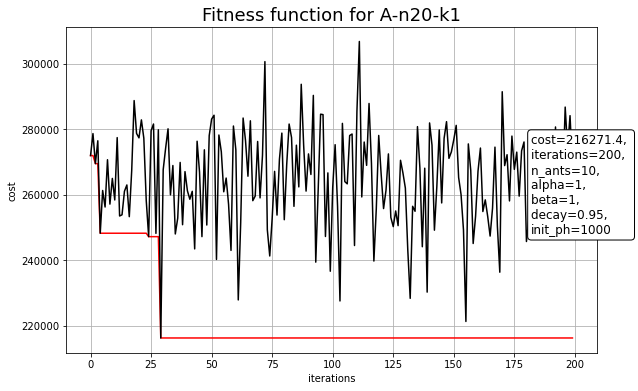

In [89]:
case.plot_function()

In [84]:
#import folium
#
##m = folium.Map(location=[43.652597, -79.384669], tiles="CartoDB positron", zoom_start=13)
#
#
#depot_longitude       =  -79.383292
#depot_latitude        =  43.652224
#customer_count        =  10
#
##coords_long_lat       = np.random.randint(low=[latitude_min, latitude_max], high=[longitude_max, latitude_max], size=(number_cities, 2))
#
#demand = np.random.randint(1, 11, customer_count-1)
#demand = np.insert(demand,0,0)
#print(demand)
#
#df_map = pd.DataFrame({"longitude":np.random.normal(depot_longitude, 0.008, customer_count),
#                       "latitude":np.random.normal(depot_latitude, 0.008, customer_count),
#                       "demand":demand})
#
#
#print(df_map)

In [29]:
import folium
m = folium.Map(location=[43.652597, -79.384669], tiles="CartoDB positron" , zoom_start=10)

for index, row in df_map.iterrows():
    icon_house = "circle"
    color      = "blue"
    if index == "A":
        icon_house = "home"
        color      = "red"
    popup_demand = "Demand: " + str(row['demand'])
    folium.Marker(location=[row['latitude'], row['longitude']], tooltip="click for more", popup = popup_demand, icon=folium.Icon(color=color ,icon=icon_house, prefix='fa')).add_to(m)
m

In [30]:
col = ['blue', 'green', 'red', 'pink', 'orange', 'yellow', 'black', 'brown']
i   = 0


for truck in test534:
    for test in range(len(truck)-1):
        dot1 = truck[test]-1
        dot2 = truck[test+1]-1
        dot1_loc = df_map.iloc[dot1]
        dot2_loc = df_map.iloc[dot2]
        

        line = [(dot1_loc['latitude'],dot1_loc['longitude']), (dot2_loc['latitude'],dot2_loc['longitude'])]
        
        folium.PolyLine(line,
                color=col[(i) % len(col)],
                weight=5,
                opacity=0.8).add_to(m)
    i += 1

m